<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/transfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

from numpy.random import seed
import tensorflow as tf

tf.random.set_seed(100)

In [0]:
os.environ['KAGLE_USERNAME']= "jimitogni"
os.environ['KAGLE_KEY']= "6ba3f466a063e70addd26514bb2cf41d"



In [0]:
def search_dir(type="normal", num=6):
  #funcao que ajuda scanear um diretorio
  counter = 0

  for file in os.listdir(train_dir + type.upper()+"/"):
    if counter == num:
      break

    if file.endswith(".jpeg"):
      print(file)

    counter += 1


In [0]:
def plot_images(type="normal", num=6):
  #auxilia ao plotar imagens
  counter = 0

  fig = plt.figure(figsize=(10,8))

  for file in os.listdir(train_dir + type.upper()):
    if file.endswith(".jpeg"):
      if counter == num:
        break

      img = mpimg.imread(train_dir + type.upper()+"/"+file)
      plt.subplot(231+counter)
      plt.title(file.split('.')[0])
      imgplot = plt.imshow(img)

      counter += 1


In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: #set up subplot in first call
    plt.subplots(figsize=(10,10))
    plt.tight_layout()
  ax = plt.subplot(subplot)
  #ax.set_facecolor('F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model' + title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [22]:

%%shell
pip install kaggle
export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=6ba3f466a063e70addd26514bb2cf41d

kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip -q chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
#explore data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
#diretorios
train_dir = "chest_xray/train/"
val_dir = "chest_xray/val/"
test_dir = "chest_xray/test/"

In [45]:
search_dir(type="pneumonia", num=10)
search_dir(type="normal", num=10)

person1180_virus_2011.jpeg
person1453_bacteria_3770.jpeg
person481_virus_983.jpeg
person469_bacteria_1993.jpeg
person1162_bacteria_3107.jpeg
person320_virus_647.jpeg
person1021_virus_1711.jpeg
person721_virus_1340.jpeg
person1576_bacteria_4120.jpeg
person716_virus_1314.jpeg
NORMAL2-IM-1123-0001.jpeg
IM-0602-0001.jpeg
IM-0730-0001.jpeg
IM-0529-0001.jpeg
NORMAL2-IM-0932-0001.jpeg
NORMAL2-IM-0424-0001.jpeg
IM-0298-0001.jpeg
NORMAL2-IM-0892-0001.jpeg
IM-0122-0001.jpeg
NORMAL2-IM-1094-0001.jpeg


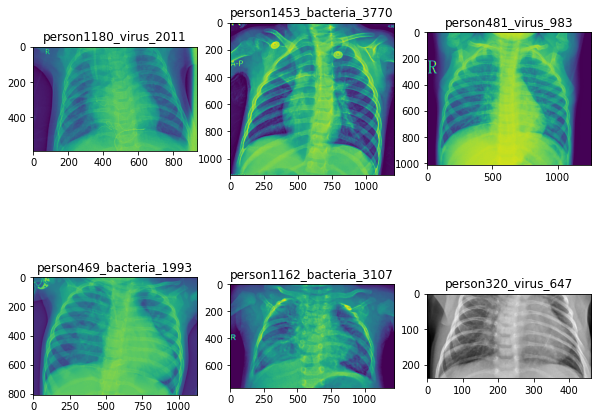

In [89]:
plot_images(type="pneumonia", num=6)

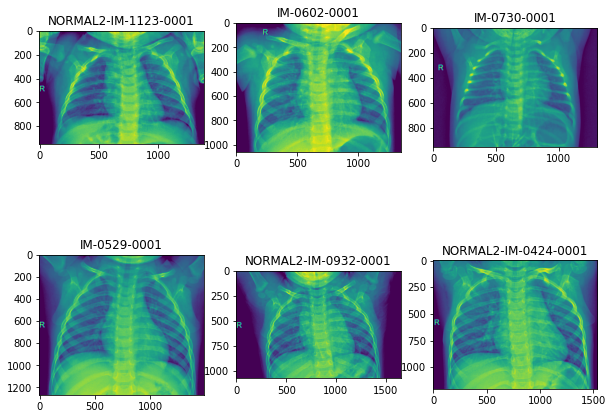

In [47]:
plot_images(type="normal", num=6)

In [0]:
# MODEL
# pre trerinado

In [0]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

In [0]:
pre_model = InceptionV3(weights="imagenet")

In [51]:
img = image.load_img("/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)

for index, res in enumerate(decode_predictions(y)[0]):
  print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100* res[2]))

1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


In [32]:
#img = mpimg.imread("example_2.jpg")
#imgplot = plt.imshow(img)

FileNotFoundError: ignored

In [0]:
#preparação dos dados

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 163

#criando gerador para dados de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1) #cria um gerador de imagem no abstract

In [54]:
train_generator = train_datagen.flow_from_directory(
    train_dir, #diretorio com os dados de treino
    target_size=(150,150), #tamanho da imagem que queremos
    batch_size=batch_size, #quantos arquivos para ler de cada vez
    class_mode="categorical"
)

Found 5216 images belonging to 2 classes.


In [55]:
#gerando dados para validação

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 16 images belonging to 2 classes.


In [56]:
#gerando dados para teste

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [0]:
#MODELO PARA TREINO

In [0]:
import keras

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

for layer in base_model.layers:
  layer.trainable = False #congela os layers para nao treinar

final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #modelo final

In [0]:
final_model.compile(loss="categorical_crossentropy", # log loss
                    optimizer="adam",
                    metrics=["accuracy"])

In [65]:
fit_history = final_model.fit_generator(
    train_generator, #generator dados treino
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator, #dados gerados para validação
    validation_steps=len(val_generator)
)

Epoch 1/5
32/32 [==============================] - 78s 2s/step - loss: 0.7267 - accuracy: 0.8092 - val_loss: 2.2339 - val_accuracy: 0.6250
Epoch 2/5
32/32 [==============================] - 67s 2s/step - loss: 0.2568 - accuracy: 0.9020 - val_loss: 1.3189 - val_accuracy: 0.6875
Epoch 3/5
32/32 [==============================] - 68s 2s/step - loss: 0.2394 - accuracy: 0.9032 - val_loss: 1.3873 - val_accuracy: 0.6875
Epoch 4/5
32/32 [==============================] - 68s 2s/step - loss: 0.2150 - accuracy: 0.9156 - val_loss: 1.3819 - val_accuracy: 0.7500
Epoch 5/5
32/32 [==============================] - 70s 2s/step - loss: 0.2162 - accuracy: 0.9137 - val_loss: 1.6740 - val_accuracy: 0.6875


In [66]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

KeyError: ignored

In [67]:
result = final_model.evaluate_generator(test_generator, steps=len(test_generator))
print('Loss: ', result[0])
print('Accuracy: ', result[1])

Loss:  4.291743755340576
Accuracy:  0.6266025900840759


In [68]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [69]:
#gerando todos os preditores
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator, steps = nb_samples).argmax(axis=-1)

predict

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [70]:
#gerandor de rotulos verdadeiros
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

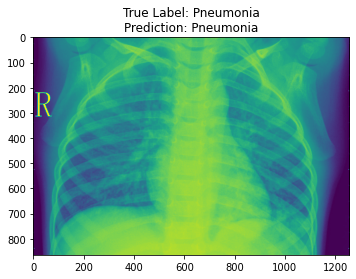

In [87]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg" #@param {type:"string"}

img = image.load_img(filename, target_size=(150, 150))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)